## Алгоритмы анализа стереопар изображений

На этом семинаре будет разобрана тема стереозрения, которая заключается в применении нескольких видов камер для получения информации о глубине обзора. Используя стереозрение, можно определить местоположение точки в мире по ее изображениям в разных ракурсах камеры.

Термин охватывает многие приложения, работающие с несколькими видами отслеживаемого объекта под разными углами. Это могут быть стереокамеры, которые имеют несколько камер на одних и тех же устройствах, или разные виды с разных устройств.

1. 3D реконструкция с нескольких ракурсов. Знаем параметры калибровки каждой из камер. Необходимо найти положение 3D объекта в мировых координатах.

2. Оценка на основе движения (Structure From Motion). Не знаем параметры калибровки, необходимо одновременно восстановить и координаты, и калибровку.

1 задача проще в своей постановке, рассмотрим ее.

Моно/Стерео зрение
![](https://raw.githubusercontent.com/polygon-software/python-visual-odometry/master/img/chapter_8/1_projection_and_stereo.png)

Идея: можем найти пересечение лучей, исходящих из разных камер, и по параметрам камеры определить расстояние до объекта. Вы можете ощутить эффект стереовидения на основе своих глаз. Поставьте палец перед глазами. Закройте один глаз, потом другой глаз. Вы заметите, что пальцы, кажется, прыгают слева направо. Это наблюдаемое горизонтальное смещение называется диспаратностью (расхождением, disparity).

![](https://raw.githubusercontent.com/polygon-software/python-visual-odometry/master/img/chapter_8/3_stereo_cases.png)

Рассмотрим более простой случай с выровненными (ректифицированными) камерами.

![](https://raw.githubusercontent.com/polygon-software/python-visual-odometry/master/img/chapter_8/4_stereo_vision_simple.png)

Вопрос 1. Зная f (фокальное расстояние камер), b (расстояние между камерами), $u_l$, $u_r$, определить расстояние до объекта $Z_{p}$. После получения выражения, объясните, что такое диспраратность на примере цифровых изображений.

$disparity = u_l - u_r = \frac{bf}{Z}  $

Диспаратность - это расстояние между точками изображения в проекции разных камер, соответсвующие одной точке в 3D сцены. Объекты, которые находятся близко, сдвинутся на большое расстояние, в то время как дальние на маленькое. 

In [1]:
%%bash
wget https://raw.githubusercontent.com/jagracar/OpenCV-python-tests/master/OpenCV-tutorials/data/tsukuba_l.png -O tsukuba_l.png
wget https://raw.githubusercontent.com/jagracar/OpenCV-python-tests/master/OpenCV-tutorials/data/tsukuba_r.png -O tsukuba_r.png

--2022-04-13 14:06:13--  https://raw.githubusercontent.com/jagracar/OpenCV-python-tests/master/OpenCV-tutorials/data/tsukuba_l.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85192 (83K) [image/png]
Saving to: ‘tsukuba_l.png’

     0K .......... .......... .......... .......... .......... 60% 3.98M 0s
    50K .......... .......... .......... ...                  100% 16.8M=0.01s

2022-04-13 14:06:13 (5.72 MB/s) - ‘tsukuba_l.png’ saved [85192/85192]

--2022-04-13 14:06:13--  https://raw.githubusercontent.com/jagracar/OpenCV-python-tests/master/OpenCV-tutorials/data/tsukuba_r.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubuserco

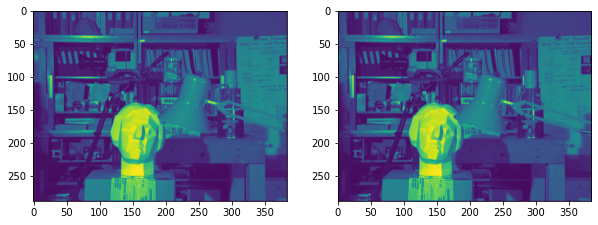

In [2]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

imgL = cv2.imread('tsukuba_l.png',0)
imgR = cv2.imread('tsukuba_r.png',0)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(imgL)
ax[1].imshow(imgR)

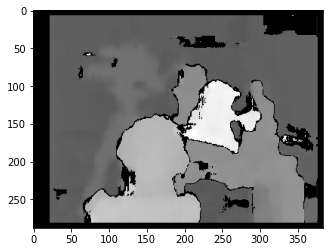

In [3]:
#see params here
#https://docs.opencv.org/4.5.0/d9/dba/classcv_1_1StereoBM.html#a04fdf00525f82fe708d556e2cd359004

stereo = cv2.StereoBM_create(
    numDisparities=16, #search range for each pixel
    blockSize=15,      #linar size of the blocks
    #Smaller block size gives more detailed disparity map,
    #but there is higher chance for algorithm to find a wrong correspondence.
)
disparity = stereo.compute(imgL, imgR)

plt.imshow(disparity, cmap='gray')

Рассмотрим базовый жадный алгоритм наилучшего соответсвия (winner takes all, WTA) между изображениями с помощью блоков и метрики близости (sum of absolute difference, SAD).

In [4]:
## define algorightm by hands

import IPython
IPython.display.Image('alg.png')

In [5]:
def compare_blocks(
    block_left: np.array,
    block_right: np.array,
) -> float:
    '''
    Takes blocks from left/right image
    and return similarity metric (for example L1, L2 etc)
    '''
    metric = np.sqrt(np.sum((block_left - block_right)**2))
    return metric

def get_disparity(
    imgL: np.array, #(H, W) Grayscale
    imgR: np.array, #(H, W) Grayscale
    numDisparities: int, #the same in opencv
    blockSize: int, #the same in opencv
) -> np.array:

    assert imgL.shape == imgR.shape, 'Images are not equal'

    H, W = imgL.shape
    disparity_map = np.zeros_like(imgL) #(H, W)
    blockSize //= 2

    for i in range(blockSize, H - blockSize):
        for j in range(blockSize + numDisparities, W - blockSize): 

            #define base block to compare
            #using blockSize and i, j

            block_left = imgL[i - blockSize : i + blockSize, j - blockSize : j + blockSize]
            metrics = []

            for k in range(1, numDisparities):

                #define secondary block to compare
                #using blockSize and i, j
                block_right = imgR[i - blockSize : i + blockSize, j - k - blockSize : j - k + blockSize]

                metrics.append(
                    compare_blocks(
                      block_left,
                      block_right
                    )
                )
            
            best_index = np.argmin(metrics)

            #convert index to disparity
            #and fill it in disparity_map

            disparity_map[i, j] = best_index

    return disparity_map

In [6]:
disparity_map = get_disparity(imgL, imgR, 16, 15)

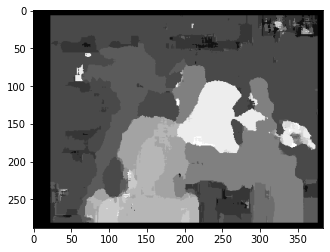

In [7]:
plt.imshow(disparity_map, cmap='gray')
plt.show()

In [8]:
def my_disparity(
    imgL: np.array, #(H, W) Grayscale
    imgR: np.array, #(H, W) Grayscale
    numDisparities: int, #the same in opencv
    blockSize: int, #the same in opencv
) -> np.array:

    disparity_map = get_disparity(imgL, imgR, numDisparities, blockSize)

    return cv2.medianBlur(disparity_map, 15)

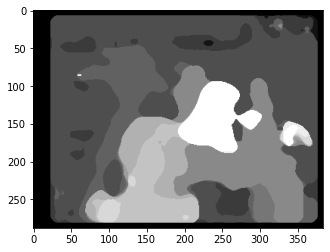

In [9]:
my_disparity_map = my_disparity(imgL, imgR, 16, 15)
plt.imshow(my_disparity_map, cmap='gray')
plt.show()

In [10]:
print('Previous diff: ', np.mean(abs(disparity_map - disparity)))
print('My diff: ', np.mean(abs(my_disparity_map - disparity)))

Previous diff:  86.98342556423611
My diff:  86.97374131944444


Вопрос. Заполняет ли алгоритм все пиксели глубины? Как можно улучшить его? (Например, рассмотрите вариант, когда `metrics.min()` выдает большое число, что делать в этом случае? Или предложите свою версию.) Приведите дополнительную реализацию.

- Нет, есть черные пиксели, где значение метрики имеет большое минимальное значения при любых сдвигах, поэтому берется первое. Можно применить сглаживающий фильтр, чтобы улучшить disparcity map.

Вопрос. Сравните свою реализацию с opencv StereoBM с помощью попиксельного сравнения карт диспаратности.

Вопрос. Как еще с помощью пройденных классических алгоритмов можно построить карту дипаратности? Приведите кратное описание придуманного/существующего алгоритма.

- Я думаю, что в дополнении к текущей интерполяции можно добавить edge detection, сделать какой-то штраф или учет сдвига линий.
- Можно воспользоваться дескриптором, чтобы сматчить какие-то ключевые точки изображений, и учитывать это впоследствии.